Summary Statistics of Wait Times:
       triage_mean  cubicle_mean  doctor_wait_time_mean  \
count   250.000000    250.000000             250.000000   
mean     27.222625     64.947858              17.265550   
std       1.557385      2.554469               0.472140   
min      16.090348     44.922036              13.978173   
25%      26.986668     64.163025              17.152550   
50%      27.336864     64.420630              17.217468   
75%      27.819966     65.128281              17.425939   
max      29.826040     74.176908              20.766185   

       minor_injury_patients_mean  mean_time_in_system  number_of_patients  
count                  250.000000           250.000000          250.000000  
mean                   369.310204           130.104733           54.492000  
std                      5.276271            20.351270            4.899178  
min                    346.863015            85.947474           37.000000  
25%                    365.729324           116.4

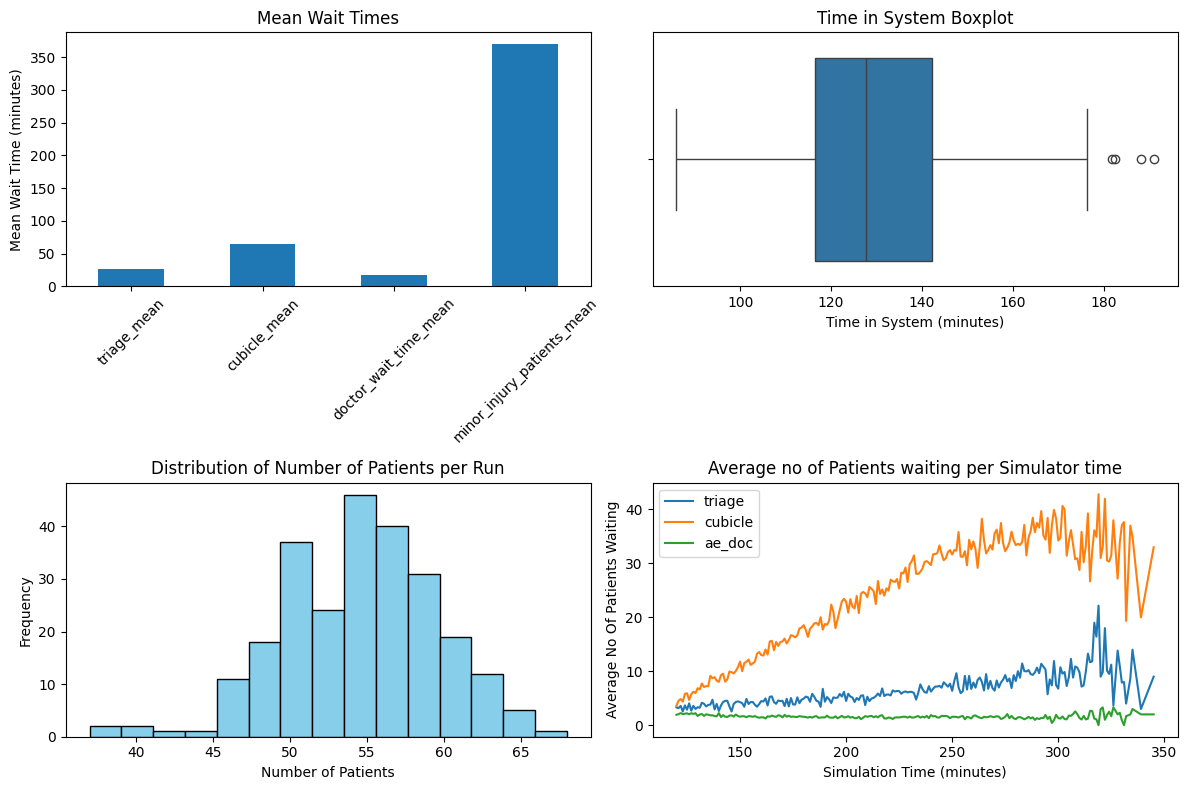

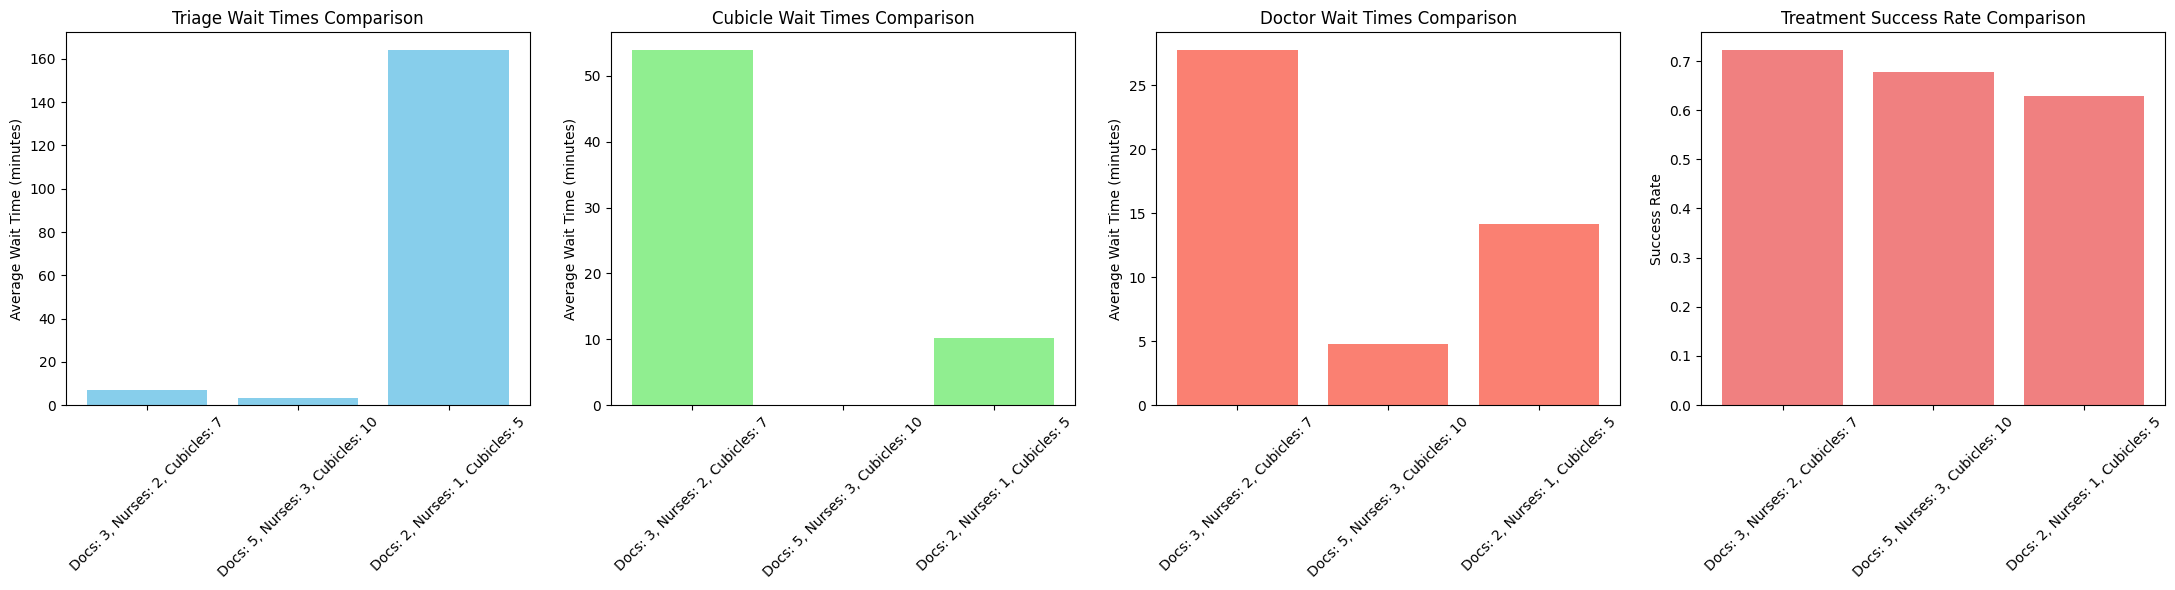

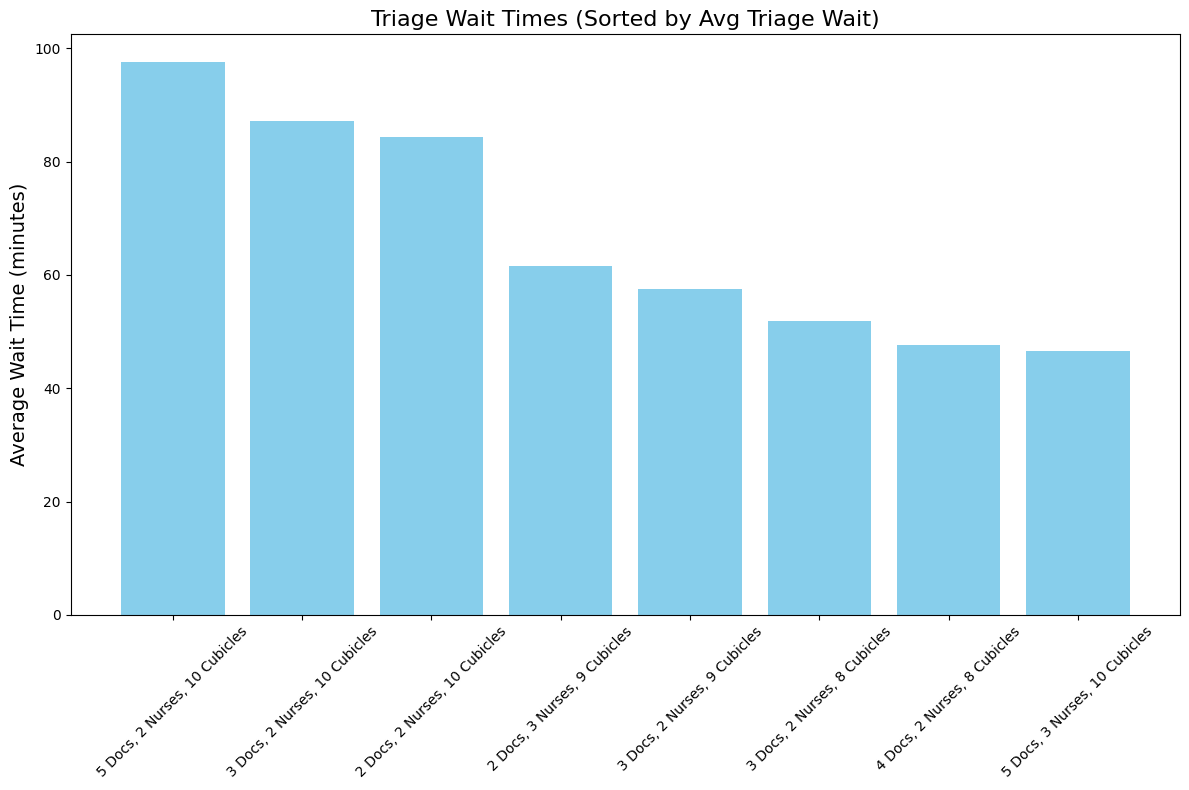

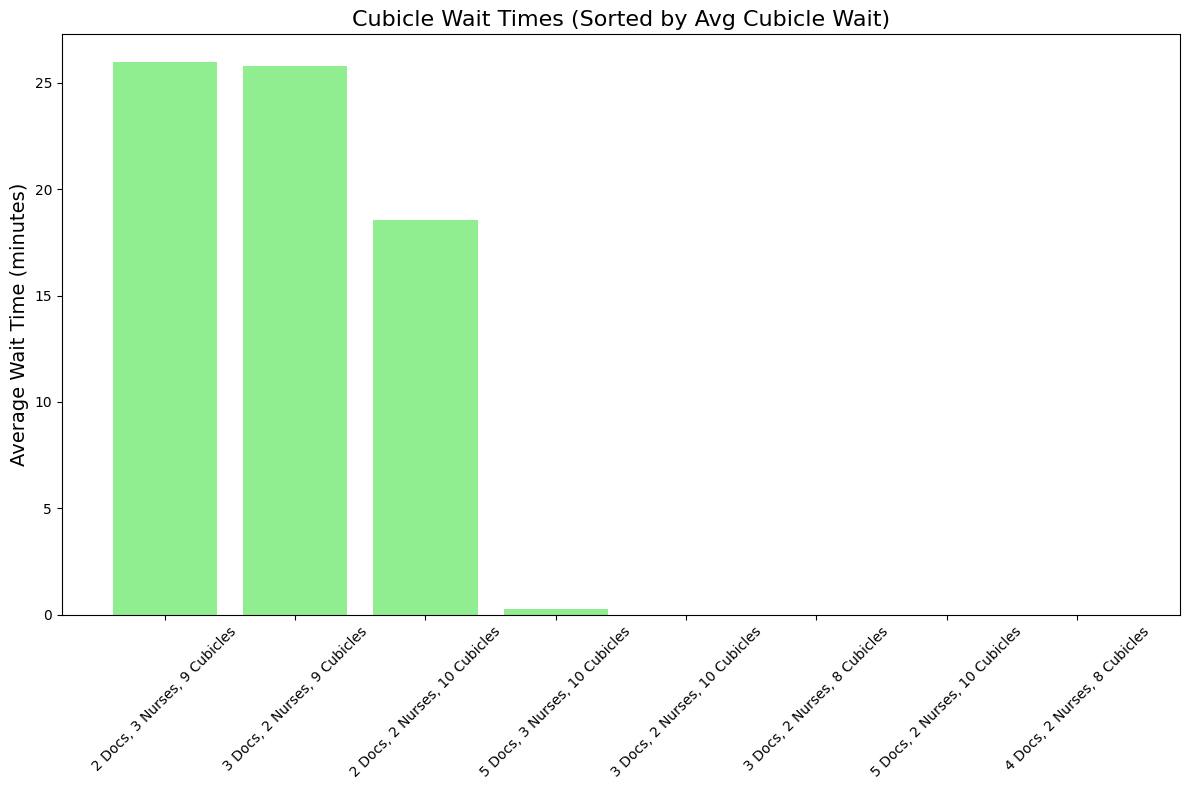

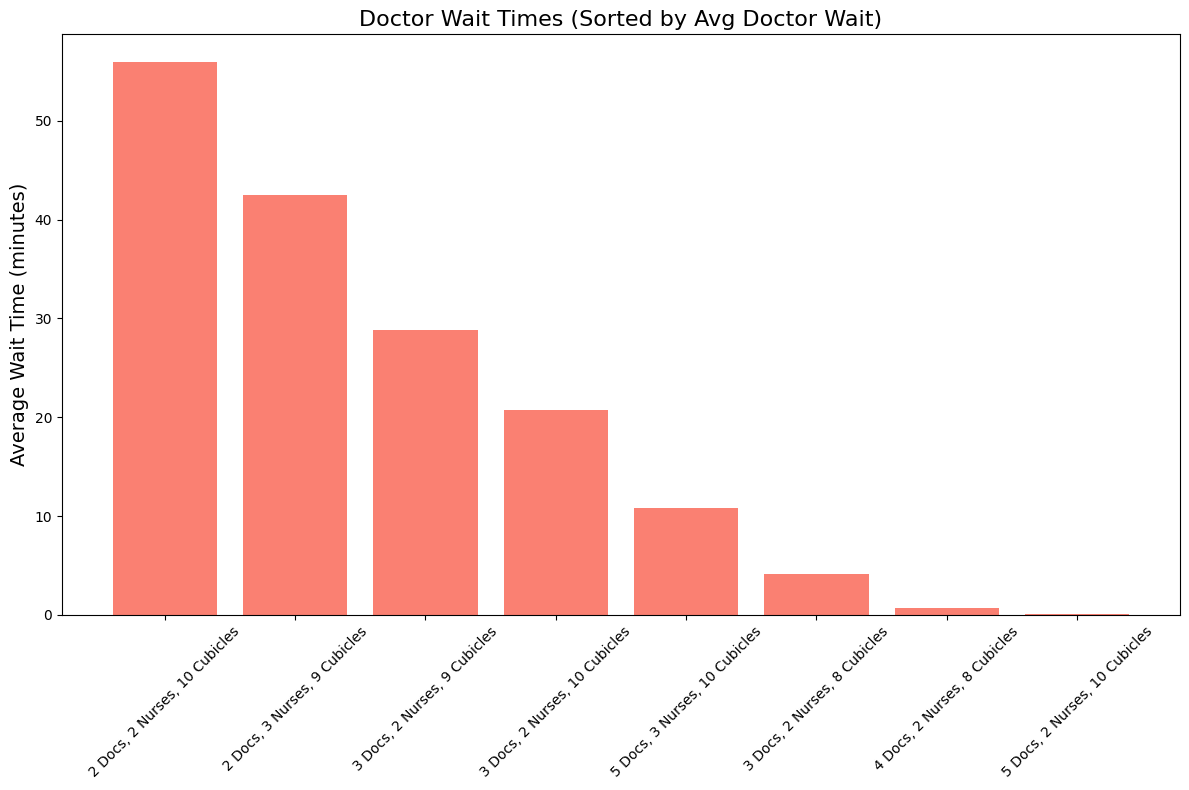

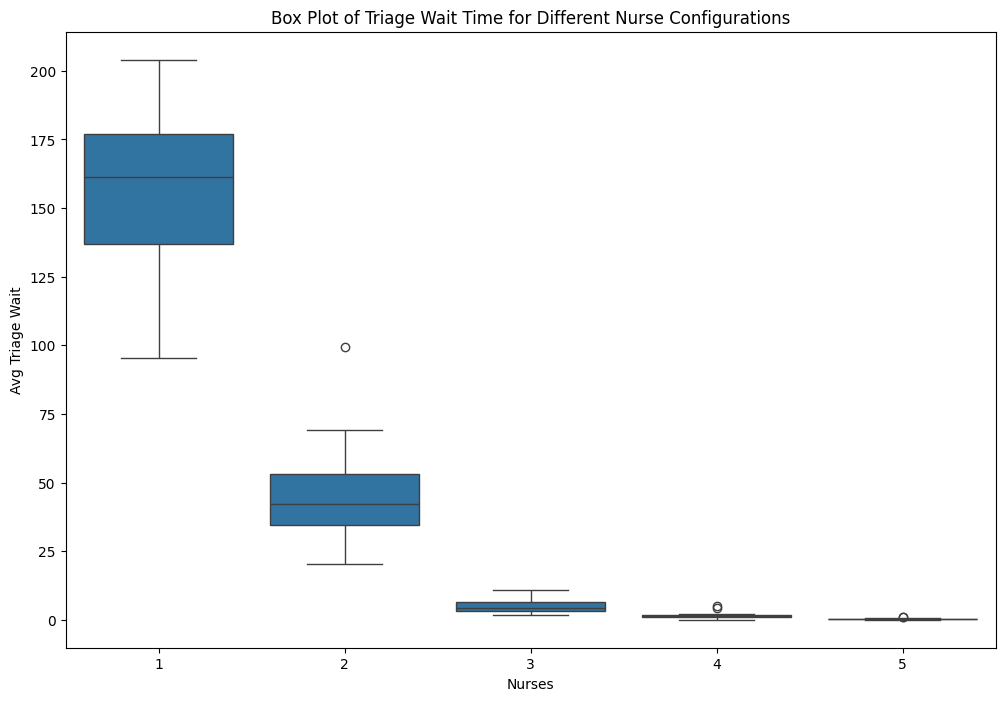

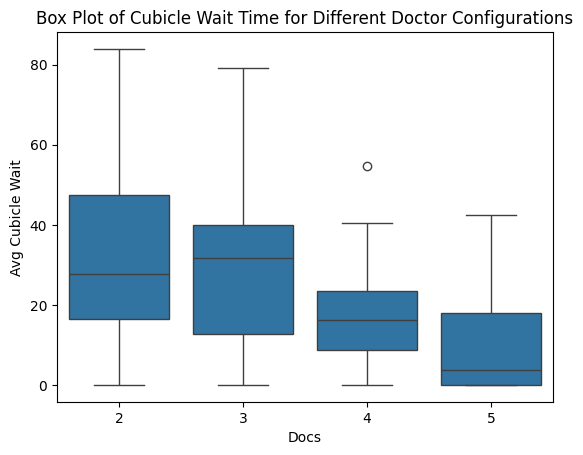

     Nurses  Docs  Cubicles  Avg Triage Wait  Avg Cubicle Wait  Avg Doc Wait
0         1     2         5        95.364957         12.937885     28.816767
1         1     2         6       111.856340          1.101228     30.486952
2         1     2         7       113.011728          4.840470     25.322922
3         1     2         8       137.079423         12.647169     26.308298
4         1     2         9       143.183471          0.103972     14.901319
..      ...   ...       ...              ...               ...           ...
115       5     5         6         1.017780         28.772032      4.789121
116       5     5         7         0.066740         24.976485     11.267674
117       5     5         8         0.962224         11.120635     11.679296
118       5     5         9         0.227447          1.305511     11.433305
119       5     5        10         0.048230          0.012191      6.955631

[120 rows x 6 columns]


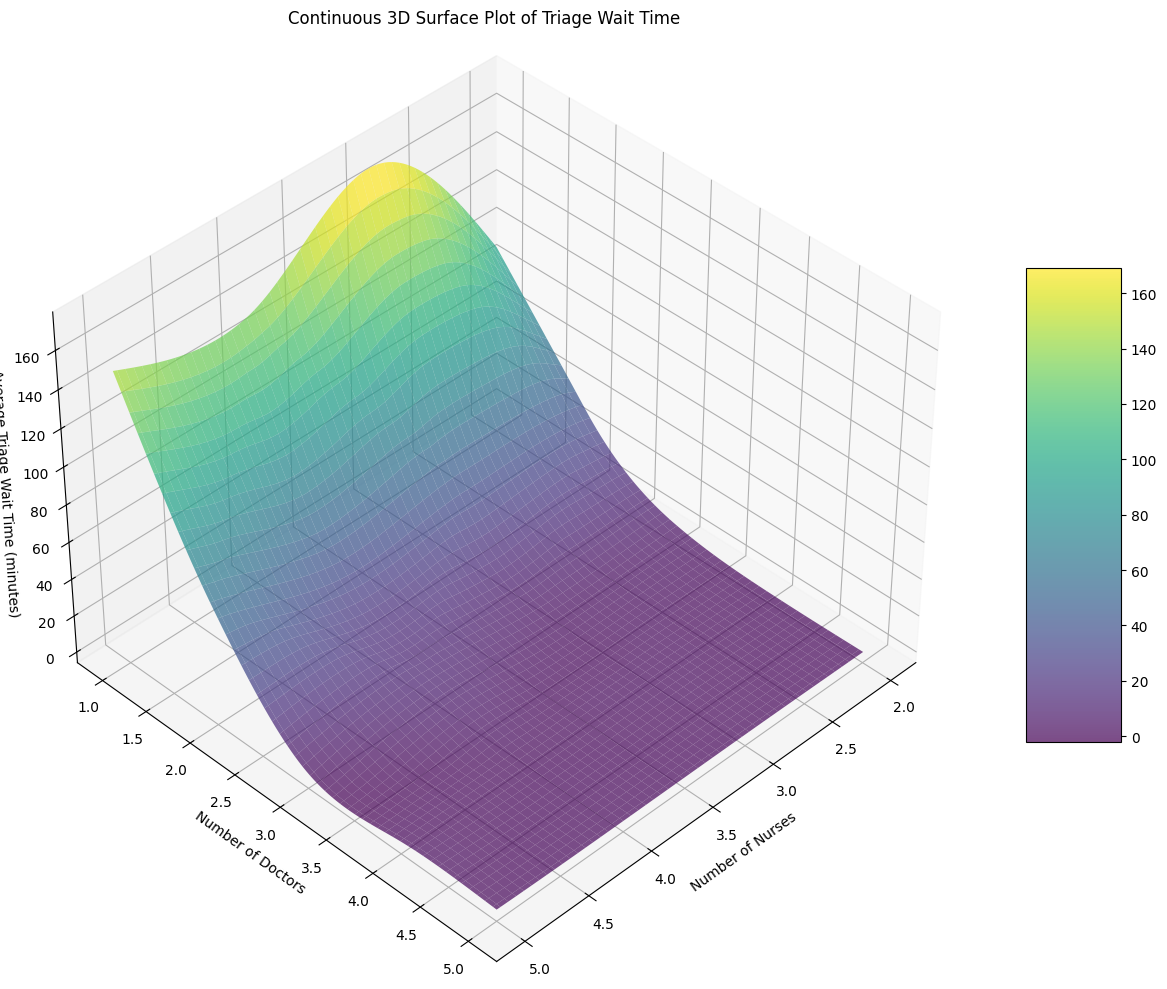

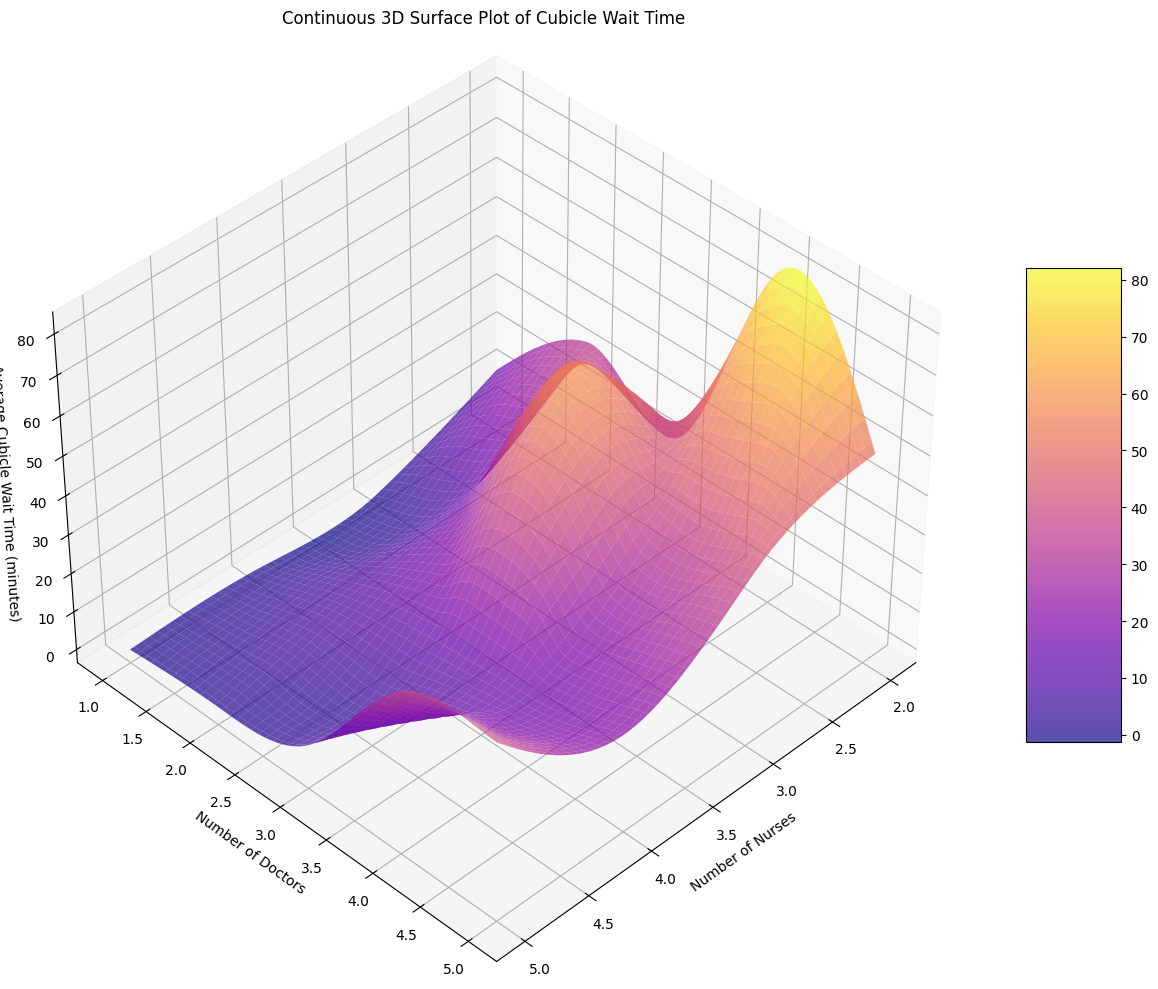

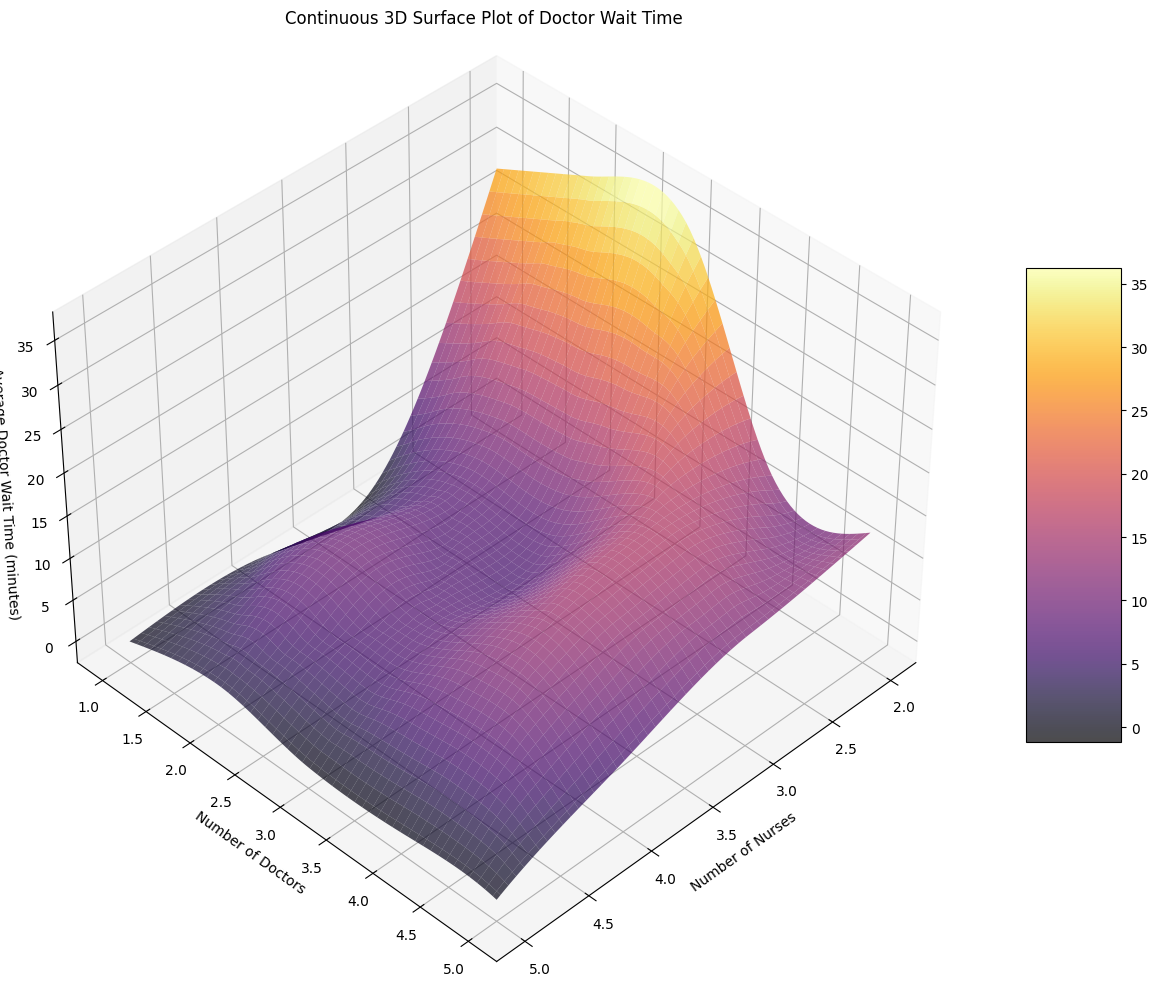

In [5]:
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
from statistics import mean
import simpy

# Define the lognormal distribution class
class Lognormal:
    def __init__(self, mean, stdev, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma

    def normal_moments_from_lognormal(self, m, v):
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2 / phi)
        sigma = math.sqrt(math.log(phi**2 / m**2))
        return mu, sigma

    def sample(self):
        return self.rand.lognormal(self.mu, self.sigma)

# Global parameters class
class p:
    inter = 5
    mean_doc_consult = 30
    stdev_doc_consult = 10
    mean_nurse_triage = 10
    stdev_nurse_triage = 5
    number_docs = 3
    number_nurses = 2
    ae_cubicles = 7
    mean_ip_wait = 90
    warm_up = 120
    sim_duration = 480
    number_of_runs = 250
    wait_triage = []
    wait_cubicle = []
    wait_doc = []
    mean_doc_consult_miu = 20
    stdev_doc_consult_miu = 7
    number_docs_miu = 2
    number_nurses_miu = 3
    miu_cubicles = 5
    wait_doc_miu = []

# Tracker class for simulation metrics
class Tracker:
    def __init__(self):
        self.env_time_all = []
        self.waiters = {'triage': [], 'cubicle': [], 'ae_doc': [], 'miu_doc': []}
        self.waiters_all = {'triage': [], 'cubicle': [], 'ae_doc': [], 'miu_doc': []}
        self.results_df = pd.DataFrame(columns=["P_ID", "Priority", "TriageOutcome", "TimeInSystem"])

    def plot_data(self, env_time, type):
        if env_time > p.warm_up:
            self.waiters_all[type].append(len(self.waiters[type]))
            self.env_time_all.append(env_time)

    def mean_priority_wait(self):
        self.priority_means = {}
        for i in range(1, 6):
            try:
                priority_times = self.results_df[self.results_df['Priority'] == i]['TimeInSystem']
                if len(priority_times) > 0:
                    self.priority_means[f"Priority{i}"] = mean(priority_times)
                else:
                    self.priority_means[f"Priority{i}"] = np.nan
            except Exception as e:
                self.priority_means[f"Priority{i}"] = np.nan



    def priority_count(self):
        self.priority_counts = {}
        for i in range(1, 6):
            self.priority_counts[f"Priority{i}"] = len(self.results_df[self.results_df['Priority'] == i]['TimeInSystem'])

# Patient class
class AEPatient:
    def __init__(self, p_id):
        self.p_id = p_id
        self.time_in_system = 0
        self.set_priority()
        self.set_triage_outcome()

    def set_priority(self):
        self.priority = random.choices([1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.2, 0.1])[0]

    def set_triage_outcome(self):
        if self.priority < 5:
            self.triage_outcome = 'AE'
        else:
            self.triage_outcome = random.choices(['home', 'MIU'], [0.2, 0.8])[0]

# Main simulation model class
class AEModel:
    def __init__(self):
        self.env = simpy.Environment()
        self.patient_counter = 0
        self.doc = simpy.PriorityResource(self.env, capacity=p.number_docs)
        self.nurse = simpy.Resource(self.env, capacity=p.number_nurses)
        self.cubicle = simpy.PriorityResource(self.env, capacity=p.ae_cubicles)
        self.doc_miu = simpy.Resource(self.env, capacity=p.number_docs_miu)
        self.nurse_miu = simpy.Resource(self.env, capacity=p.number_nurses_miu)
        self.cubicle_miu = simpy.Resource(self.env, capacity=p.miu_cubicles)

    def generate_ae_arrivals(self):
        while True:
            self.patient_counter += 1
            ae_p = AEPatient(self.patient_counter)
            self.env.process(self.attend_ae(ae_p))
            yield self.env.timeout(random.expovariate(1.0 / p.inter))

    def attend_ae(self, patient):
        triage_queue_start = self.env.now
        track.plot_data(self.env.now, 'triage')
        track.plot_data(self.env.now, 'cubicle')
        track.plot_data(self.env.now, 'ae_doc')

        with self.nurse.request() as req:
            track.waiters['triage'].append(patient)
            yield req
            track.waiters['triage'].pop()
            triage_queue_end = self.env.now
            if self.env.now > p.warm_up:
                p.wait_triage.append(triage_queue_end - triage_queue_start)

            sampled_triage_duration = Lognormal(p.mean_nurse_triage, p.stdev_nurse_triage).sample()
            yield self.env.timeout(sampled_triage_duration)

        if patient.triage_outcome == 'AE':
            cubicle_queue_start = self.env.now
            with self.cubicle.request(priority=patient.priority) as req_cub:
                track.waiters['cubicle'].append(patient)
                yield req_cub
                track.waiters['cubicle'].pop()
                cubicle_queue_end = self.env.now
                if self.env.now > p.warm_up:
                    p.wait_cubicle.append(cubicle_queue_end - cubicle_queue_start)

                doc_queue_start = self.env.now
                with self.doc.request(priority=patient.priority) as req_doc:
                    track.waiters['ae_doc'].append(patient)
                    yield req_doc
                    track.waiters['ae_doc'].pop()
                    doc_queue_end = self.env.now
                    if self.env.now > p.warm_up:
                        p.wait_doc.append(doc_queue_end - doc_queue_start)

                    sampled_consult_duration = Lognormal(p.mean_doc_consult, p.stdev_doc_consult).sample()
                    yield self.env.timeout(sampled_consult_duration)

                if random.uniform(0, 1) < 0.3:
                    yield self.env.timeout(random.expovariate(1.0 / p.mean_ip_wait))

        elif patient.triage_outcome == 'MIU':
            with self.cubicle_miu.request() as req_cub:
                yield req_cub
                with self.doc_miu.request() as req:
                    yield req
                    if self.env.now > p.warm_up:
                        p.wait_doc_miu.append(self.env.now)

        patient.time_in_system = self.env.now - triage_queue_start
        if self.env.now > p.warm_up:
            df_to_add = pd.DataFrame({
                "P_ID": [patient.p_id],
                "Priority": [patient.priority],
                "TriageOutcome": [patient.triage_outcome],
                "TimeInSystem": [patient.time_in_system]
            })
            track.results_df = pd.concat([track.results_df, df_to_add.set_index("P_ID")], ignore_index=False)

    def run(self):
        self.env.process(self.generate_ae_arrivals())
        self.env.run(until=p.warm_up + p.sim_duration)
        track.mean_priority_wait()
        track.priority_count()
        return mean(p.wait_triage), mean(p.wait_cubicle), mean(p.wait_doc), mean(p.wait_doc_miu)

# Initialize simulation tracking
all_runs_triage_mean = []
all_runs_cubicle_mean = []
all_runs_doc_mean = []
all_runs_miu_doc_mean = []
all_time_in_system = []
all_number_of_patients = []

all_run_time_wait_key = {'triage': {}, 'cubicle': {}, 'ae_doc': {}, 'miu_doc': {}}
all_run_priority_time_in_system = {f"Priority{i}": [] for i in range(1, 6)}
all_run_priority_counts = {f"Priority{i}": [] for i in range(1, 6)}

# Run the simulation multiple times
for run in range(p.number_of_runs):
    track = Tracker()
    my_ae_model = AEModel()
    triage_mean, cubicle_mean, doc_mean, miu_mean = my_ae_model.run()
    all_runs_triage_mean.append(triage_mean)
    all_runs_cubicle_mean.append(cubicle_mean)
    all_runs_doc_mean.append(doc_mean)
    all_runs_miu_doc_mean.append(miu_mean)
    all_number_of_patients.append(len(track.results_df))

    for k in all_run_time_wait_key:
        for t, w in zip(track.env_time_all, track.waiters_all[k]):
            all_run_time_wait_key[k].setdefault(round(t), []).append(w)
        all_run_time_wait_key[k] = dict(sorted(all_run_time_wait_key[k].items()))

    all_time_in_system.append(track.results_df['TimeInSystem'].mean())
    for p_id in track.priority_means:
        all_run_priority_time_in_system[p_id].append(track.priority_means[p_id])
    for p_id in track.priority_counts:
        all_run_priority_counts[p_id].append(track.priority_counts[p_id])

# Create DataFrames for results
wait_times_df = pd.DataFrame({
    "triage_mean": all_runs_triage_mean,
    "cubicle_mean": all_runs_cubicle_mean,
    "doctor_wait_time_mean": all_runs_doc_mean,
    "minor_injury_patients_mean": all_runs_miu_doc_mean,
    "mean_time_in_system": all_time_in_system,
    "number_of_patients": all_number_of_patients
})

# Results summary
summary_stats = wait_times_df.describe()
print("Summary Statistics of Wait Times:")
print(summary_stats)

# Visualization of results
plt.figure(figsize=(12, 8))

# Mean Wait Times Bar Chart
plt.subplot(2, 2, 1)
wait_times_df[['triage_mean', 'cubicle_mean', 'doctor_wait_time_mean', 'minor_injury_patients_mean']].mean().plot(kind='bar')
plt.title('Mean Wait Times')
plt.ylabel('Mean Wait Time (minutes)')
plt.xticks(rotation=45)

# Time in System Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(data=wait_times_df, x='mean_time_in_system')
plt.title('Time in System Boxplot')
plt.xlabel('Time in System (minutes)')

# Patient Count Histogram
plt.subplot(2, 2, 3)
# Set the number of bins or define specific bin edges
num_bins = 15  # You can adjust this number for smoother results
plt.hist(all_number_of_patients, bins=num_bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Patients per Run')
plt.xlabel('Number of Patients')
plt.ylabel('Frequency')


# Wait Times Over Time
plt.subplot(2, 2, 4)
for key in all_run_time_wait_key:
    # Skip plotting for 'miu_doc'
    if key == 'miu_doc':
        continue
    plt.plot(list(all_run_time_wait_key[key].keys()),
             [np.mean(v) for v in all_run_time_wait_key[key].values()], label=key)

plt.title('Average no of Patients waiting per Simulator time')
plt.xlabel('Simulation Time (minutes)')
plt.ylabel('Average No Of Patients Waiting')
plt.legend()

plt.tight_layout()
plt.show()


# Assuming the previous classes (Lognormal, p, Tracker, AEPatient, AEModel) are already defined above this point

# New Metrics to Track - Introduce patient treatment success/failure, and total treated patients
class Tracker:
    def __init__(self):
        self.env_time_all = []
        self.waiters = {'triage': [], 'cubicle': [], 'ae_doc': []}
        self.waiters_all = {'triage': [], 'cubicle': [], 'ae_doc': []}
        self.results_df = pd.DataFrame(columns=["P_ID", "Priority", "TriageOutcome", "TimeInSystem", "TreatmentSuccess"])
        self.wait_triage = []  # moved here from global scope
        self.wait_cubicle = []  # moved here from global scope
        self.wait_doc = []  # moved here from global scope
        self.successful_treatments = 0  # Track number of patients treated successfully
        self.failed_treatments = 0  # Track number of patients who leave without treatment

    def plot_data(self, env_time, type):
        if env_time > p.warm_up:
            self.waiters_all[type].append(len(self.waiters[type]))
            self.env_time_all.append(env_time)

    def update_treatment_outcome(self, treated):
        # Increment success or failure counter based on patient outcome
        if treated:
            self.successful_treatments += 1
        else:
            self.failed_treatments += 1

# Patient class - no changes needed here, unless we want to track more detailed outcomes
class AEPatient:
    def __init__(self, p_id):
        self.p_id = p_id
        self.time_in_system = 0
        self.set_priority()

    def set_priority(self):
        # Random priority based on weighted distribution
        self.priority = random.choices([1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.2, 0.1])[0]

# Main AEModel class - Adding treatment failure and success tracking
class AEModel:
    def __init__(self, track):
        self.env = simpy.Environment()
        self.patient_counter = 0
        self.track = track  # Passing Tracker instance to the model
        self.doc = simpy.PriorityResource(self.env, capacity=p.number_docs)
        self.nurse = simpy.Resource(self.env, capacity=p.number_nurses)
        self.cubicle = simpy.PriorityResource(self.env, capacity=p.ae_cubicles)

    def generate_ae_arrivals(self):
        while True:
            self.patient_counter += 1
            ae_p = AEPatient(self.patient_counter)
            self.env.process(self.attend_ae(ae_p))
            yield self.env.timeout(random.expovariate(1.0 / p.inter))

    def attend_ae(self, patient):
        # Start time for triage
        triage_queue_start = self.env.now
        self.track.plot_data(self.env.now, 'triage')

        # Wait for nurse triage
        with self.nurse.request() as req:
            yield req
            triage_queue_end = self.env.now
            self.track.wait_triage.append(triage_queue_end - triage_queue_start)

            # Nurse triage time
            sampled_triage_duration = Lognormal(p.mean_nurse_triage, p.stdev_nurse_triage).sample()
            yield self.env.timeout(sampled_triage_duration)

        # 70% chance of going to AE (Medical Emergency Cubicle)
        if random.random() < 0.7:
            cubicle_queue_start = self.env.now
            with self.cubicle.request(priority=patient.priority) as req_cub:
                yield req_cub
                cubicle_queue_end = self.env.now
                self.track.wait_cubicle.append(cubicle_queue_end - cubicle_queue_start)

                # Wait for doctor consultation
                doc_queue_start = self.env.now
                with self.doc.request(priority=patient.priority) as req_doc:
                    yield req_doc
                    doc_queue_end = self.env.now
                    self.track.wait_doc.append(doc_queue_end - doc_queue_start)

                    # Doctor consultation duration
                    sampled_consult_duration = Lognormal(p.mean_doc_consult, p.stdev_doc_consult).sample()
                    yield self.env.timeout(sampled_consult_duration)

            # Patient is treated successfully
            patient.time_in_system = self.env.now - triage_queue_start
            self.track.update_treatment_outcome(True)
            self.track.results_df = pd.concat([self.track.results_df, pd.DataFrame([{
                "P_ID": patient.p_id,
                "Priority": patient.priority,
                "TriageOutcome": "AE",
                "TimeInSystem": patient.time_in_system,
                "TreatmentSuccess": True
            }])], ignore_index=True)

        else:
            # Patient leaves without treatment (failure)
            self.track.update_treatment_outcome(False)
            patient.time_in_system = self.env.now - triage_queue_start
            self.track.results_df = pd.concat([self.track.results_df, pd.DataFrame([{
                "P_ID": patient.p_id,
                "Priority": patient.priority,
                "TriageOutcome": "Left",
                "TimeInSystem": patient.time_in_system,
                "TreatmentSuccess": False
            }])], ignore_index=True)

    def run(self):
        self.env.process(self.generate_ae_arrivals())
        self.env.run(until=p.warm_up + p.sim_duration)

# Run the simulation with different parameters, tracking success/failure rates
def run_simulation(param_sets):
    results = {}
    for param_set in param_sets:
        p.number_docs = param_set['docs']
        p.number_nurses = param_set['nurses']
        p.ae_cubicles = param_set['cubicles']

        # Initialize Tracker and AE Model
        track = Tracker()
        my_ae_model = AEModel(track)
        my_ae_model.run()

        # Store the average wait times and treatment success rates for this parameter set
        results[f"Docs: {param_set['docs']}, Nurses: {param_set['nurses']}, Cubicles: {param_set['cubicles']}"] = {
            'triage': np.mean(track.wait_triage),
            'cubicle': np.mean(track.wait_cubicle),
            'doc': np.mean(track.wait_doc),
            'success_rate': track.successful_treatments / (track.successful_treatments + track.failed_treatments)
        }

        # Clear the wait time lists for the next run
        track.wait_triage.clear()
        track.wait_cubicle.clear()
        track.wait_doc.clear()

    return results

# Define different parameter sets for comparison
param_sets = [
    {'docs': 3, 'nurses': 2, 'cubicles': 7},
    {'docs': 5, 'nurses': 3, 'cubicles': 10},
    {'docs': 2, 'nurses': 1, 'cubicles': 5}
]

# Run simulation with different parameter sets
simulation_results = run_simulation(param_sets)

# Plot side-by-side comparison of the results including Treatment Success Rate
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

# Plot Triage Wait Times
axes[0].bar(simulation_results.keys(), [r['triage'] for r in simulation_results.values()], color='skyblue')
axes[0].set_title('Triage Wait Times Comparison')
axes[0].set_ylabel('Average Wait Time (minutes)')
axes[0].tick_params(axis='x', rotation=45)

# Plot Cubicle Wait Times
axes[1].bar(simulation_results.keys(), [r['cubicle'] for r in simulation_results.values()], color='lightgreen')
axes[1].set_title('Cubicle Wait Times Comparison')
axes[1].set_ylabel('Average Wait Time (minutes)')
axes[1].tick_params(axis='x', rotation=45)

# Plot Doctor Wait Times
axes[2].bar(simulation_results.keys(), [r['doc'] for r in simulation_results.values()], color='salmon')
axes[2].set_title('Doctor Wait Times Comparison')
axes[2].set_ylabel('Average Wait Time (minutes)')
axes[2].tick_params(axis='x', rotation=45)

# Plot Treatment Success Rate
axes[3].bar(simulation_results.keys(), [r['success_rate'] for r in simulation_results.values()], color='lightcoral')
axes[3].set_title('Treatment Success Rate Comparison')
axes[3].set_ylabel('Success Rate')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



# Define the lognormal distribution class
class Lognormal:
    def __init__(self, mean, stdev, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma

    def normal_moments_from_lognormal(self, m, v):
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2 / phi)
        sigma = math.sqrt(math.log(phi**2 / m**2))
        return mu, sigma

    def sample(self):
        return self.rand.lognormal(self.mu, self.sigma)

# Global parameters class with randomized values
class p:
    inter = 5  # Interval between patient arrivals (minutes)
    # Default values that will be randomized during each run
    mean_doc_consult = 30  # Mean doctor consultation time (minutes)
    stdev_doc_consult = 10  # Standard deviation of doctor consultation time
    mean_nurse_triage = 10  # Mean nurse triage time (minutes)
    stdev_nurse_triage = 5  # Standard deviation of nurse triage time
    number_docs = 3  # Number of doctors
    number_nurses = 2  # Number of nurses
    ae_cubicles = 7  # Number of AE cubicles
    mean_ip_wait = 90  # Mean inpatient wait time (minutes)
    warm_up = 120  # Warm-up period (minutes)
    sim_duration = 480  # Total simulation duration (minutes)
    number_of_runs = 250  # Number of runs for Monte Carlo simulation

# Tracker class for simulation metrics
class Tracker:
    def __init__(self):
        # Initialize lists to track wait times at each step
        self.wait_triage = []    # Waiting times for triage
        self.wait_cubicle = []   # Waiting times for cubicle
        self.wait_doc = []       # Waiting times for doctor consultation

    # Method to plot data (removing undefined attributes)
    def plot_data(self, env_time, type):
        if env_time > p.warm_up:
            if type == 'triage':
                self.wait_triage.append(len(self.wait_triage))  # Track triage times
            elif type == 'cubicle':
                self.wait_cubicle.append(len(self.wait_cubicle))  # Track cubicle wait times
            elif type == 'ae_doc':
                self.wait_doc.append(len(self.wait_doc))  # Track doctor wait times

# Patient class
class AEPatient:
    def __init__(self, p_id):
        self.p_id = p_id
        self.time_in_system = 0
        self.set_priority()

    def set_priority(self):
        self.priority = random.choices([1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.2, 0.1])[0]

# Main simulation model class
class AEModel:
    def __init__(self, track):
        self.env = simpy.Environment()
        self.patient_counter = 0
        self.track = track  # Passing Tracker instance to the model
        self.doc = simpy.PriorityResource(self.env, capacity=p.number_docs)
        self.nurse = simpy.Resource(self.env, capacity=p.number_nurses)
        self.cubicle = simpy.PriorityResource(self.env, capacity=p.ae_cubicles)

    def generate_ae_arrivals(self):
        while True:
            self.patient_counter += 1
            ae_p = AEPatient(self.patient_counter)
            self.env.process(self.attend_ae(ae_p))
            yield self.env.timeout(random.expovariate(1.0 / p.inter))

    def attend_ae(self, patient):
        triage_queue_start = self.env.now
        self.track.plot_data(self.env.now, 'triage')

        with self.nurse.request() as req:
            yield req
            triage_queue_end = self.env.now
            self.track.wait_triage.append(triage_queue_end - triage_queue_start)

            sampled_triage_duration = Lognormal(p.mean_nurse_triage, p.stdev_nurse_triage).sample()
            yield self.env.timeout(sampled_triage_duration)

        if random.random() < 0.7:  # 70% will go to AE
            cubicle_queue_start = self.env.now
            with self.cubicle.request(priority=patient.priority) as req_cub:
                yield req_cub
                cubicle_queue_end = self.env.now
                self.track.wait_cubicle.append(cubicle_queue_end - cubicle_queue_start)

                doc_queue_start = self.env.now
                with self.doc.request(priority=patient.priority) as req_doc:
                    yield req_doc
                    doc_queue_end = self.env.now
                    self.track.wait_doc.append(doc_queue_end - doc_queue_start)

                    sampled_consult_duration = Lognormal(p.mean_doc_consult, p.stdev_doc_consult).sample()
                    yield self.env.timeout(sampled_consult_duration)

        patient.time_in_system = self.env.now - triage_queue_start

    def run(self):
        self.env.process(self.generate_ae_arrivals())
        self.env.run(until=p.warm_up + p.sim_duration)

# Function to generate random parameters for simulation runs
def randomize_parameters():
    # Randomize doctor consultation times and nurse triage times
    p.mean_doc_consult = random.randint(20, 40)
    p.stdev_doc_consult = random.randint(5, 15)
    p.mean_nurse_triage = random.randint(8, 12)
    p.stdev_nurse_triage = random.randint(3, 7)
    p.number_docs = random.randint(2, 5)  # Random doctors
    p.number_nurses = random.randint(1, 3)  # Random nurses
    p.ae_cubicles = random.randint(5, 10)  # Random cubicles

# Run the simulation with randomized parameters
def run_simulation_with_random_params(param_sets, num_runs=10):
    results = []
    for _ in range(num_runs):
        randomize_parameters()
        track = Tracker()  # Initialize Tracker here
        my_ae_model = AEModel(track)  # Pass Tracker instance to AEModel
        my_ae_model.run()

        results.append({
            'Docs': p.number_docs,
            'Nurses': p.number_nurses,
            'Cubicles': p.ae_cubicles,
            'Avg Triage Wait': np.mean(track.wait_triage),
            'Avg Cubicle Wait': np.mean(track.wait_cubicle),
            'Avg Doctor Wait': np.mean(track.wait_doc)
        })

        # Clear lists for next run
        track.wait_triage.clear()
        track.wait_cubicle.clear()
        track.wait_doc.clear()

    return results

# Run the simulation with randomized parameters for 10 runs
simulation_results_random = run_simulation_with_random_params(param_sets=[], num_runs=10)

# Convert results to DataFrame for easy plotting
df_random_results = pd.DataFrame(simulation_results_random)

# Sort by average Triage Wait Time, Cubicle Wait Time, and Doctor Wait Time
df_random_results_sorted_triage = df_random_results.sort_values(by='Avg Triage Wait', ascending=False)
df_random_results_sorted_cubicle = df_random_results.sort_values(by='Avg Cubicle Wait', ascending=False)
df_random_results_sorted_doc = df_random_results.sort_values(by='Avg Doctor Wait', ascending=False)

import matplotlib.pyplot as plt

# Plot Triage Wait Times (sorted)
plt.figure(figsize=(12, 8))
plt.bar(df_random_results_sorted_triage['Docs'].astype(str) + " Docs, " + df_random_results_sorted_triage['Nurses'].astype(str) + " Nurses, " + df_random_results_sorted_triage['Cubicles'].astype(str) + " Cubicles",
        df_random_results_sorted_triage['Avg Triage Wait'], color='skyblue')
plt.title('Triage Wait Times (Sorted by Avg Triage Wait)', fontsize=16)
plt.ylabel('Average Wait Time (minutes)', fontsize=14)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Plot Cubicle Wait Times (sorted)
plt.figure(figsize=(12, 8))
plt.bar(df_random_results_sorted_cubicle['Docs'].astype(str) + " Docs, " + df_random_results_sorted_cubicle['Nurses'].astype(str) + " Nurses, " + df_random_results_sorted_cubicle['Cubicles'].astype(str) + " Cubicles",
        df_random_results_sorted_cubicle['Avg Cubicle Wait'], color='lightgreen')
plt.title('Cubicle Wait Times (Sorted by Avg Cubicle Wait)', fontsize=16)
plt.ylabel('Average Wait Time (minutes)', fontsize=14)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Plot Doctor Wait Times (sorted)
plt.figure(figsize=(12, 8))
plt.bar(df_random_results_sorted_doc['Docs'].astype(str) + " Docs, " + df_random_results_sorted_doc['Nurses'].astype(str) + " Nurses, " + df_random_results_sorted_doc['Cubicles'].astype(str) + " Cubicles",
        df_random_results_sorted_doc['Avg Doctor Wait'], color='salmon')
plt.title('Doctor Wait Times (Sorted by Avg Doctor Wait)', fontsize=16)
plt.ylabel('Average Wait Time (minutes)', fontsize=14)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



# Define the lognormal distribution class (same as before)
class Lognormal:
    def __init__(self, mean, stdev, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma

    def normal_moments_from_lognormal(self, m, v):
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2 / phi)
        sigma = math.sqrt(math.log(phi**2 / m**2))
        return mu, sigma

    def sample(self):
        return self.rand.lognormal(self.mu, self.sigma)


# Tracker class (same as before)
class Tracker:
    def __init__(self):
        self.wait_triage = []
        self.wait_cubicle = []
        self.wait_doc = []  # Track doctor wait times

    def record_wait_times(self, triage, cubicle, doc):
        self.wait_triage.append(triage)
        self.wait_cubicle.append(cubicle)
        self.wait_doc.append(doc)  # Record doctor wait time

# Patient class (same as before)
class AEPatient:
    def __init__(self, p_id):
        self.p_id = p_id
        self.time_in_system = 0
        self.set_priority()

    def set_priority(self):
        self.priority = random.choices([1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.2, 0.1])[0]

# Main simulation model class (same as before)
class AEModel:
    def __init__(self, track):
        self.env = simpy.Environment()
        self.patient_counter = 0
        self.track = track  # Passing Tracker instance to the model
        self.doc = simpy.PriorityResource(self.env, capacity=p.number_docs)
        self.nurse = simpy.Resource(self.env, capacity=p.number_nurses)
        self.cubicle = simpy.PriorityResource(self.env, capacity=p.ae_cubicles)

    def generate_ae_arrivals(self):
        while True:
            self.patient_counter += 1
            ae_p = AEPatient(self.patient_counter)
            self.env.process(self.attend_ae(ae_p))
            yield self.env.timeout(random.expovariate(1.0 / p.inter))

    def attend_ae(self, patient):
        triage_queue_start = self.env.now

        with self.nurse.request() as req:
            yield req
            triage_queue_end = self.env.now
            triage_wait_time = triage_queue_end - triage_queue_start

            sampled_triage_duration = Lognormal(p.mean_nurse_triage, p.stdev_nurse_triage).sample()
            yield self.env.timeout(sampled_triage_duration)

        cubicle_queue_start = self.env.now
        with self.cubicle.request(priority=patient.priority) as req_cub:
            yield req_cub
            cubicle_queue_end = self.env.now
            cubicle_wait_time = cubicle_queue_end - cubicle_queue_start

            doc_queue_start = self.env.now
            with self.doc.request(priority=patient.priority) as req_doc:
                yield req_doc
                doc_queue_end = self.env.now
                doc_wait_time = doc_queue_end - doc_queue_start

                sampled_consult_duration = Lognormal(p.mean_doc_consult, p.stdev_doc_consult).sample()
                yield self.env.timeout(sampled_consult_duration)

        patient.time_in_system = self.env.now - triage_queue_start

        # Record wait times at each stage
        self.track.record_wait_times(triage_wait_time, cubicle_wait_time, doc_wait_time)

    def run(self):
        self.env.process(self.generate_ae_arrivals())
        self.env.run(until=p.warm_up + p.sim_duration)

# Function to run the simulation with various configurations
def run_simulation_with_varying_params(nurses_range, docs_range, cubicles_range):
    results = []

    for nurses in nurses_range:
        for docs in docs_range:
            for cubicles in cubicles_range:
                p.number_nurses = nurses
                p.number_docs = docs
                p.ae_cubicles = cubicles

                track = Tracker()  # Initialize Tracker here
                my_ae_model = AEModel(track)  # Pass Tracker instance to AEModel
                my_ae_model.run()

                # Calculate average wait times for each stage
                avg_triage_wait = np.mean(track.wait_triage)
                avg_cubicle_wait = np.mean(track.wait_cubicle)
                avg_doc_wait = np.mean(track.wait_doc)

                results.append({
                    'Nurses': nurses,
                    'Docs': docs,
                    'Cubicles': cubicles,
                    'Avg Triage Wait': avg_triage_wait,
                    'Avg Cubicle Wait': avg_cubicle_wait,
                    'Avg Doc Wait': avg_doc_wait  # Include doctor wait time
                })

                # Clear the wait time lists for the next run
                track.wait_triage.clear()
                track.wait_cubicle.clear()
                track.wait_doc.clear()

    return pd.DataFrame(results)

# Define the parameter ranges for sensitivity analysis
nurses_range = range(1, 6)  # Varying number of nurses (1 to 5)
docs_range = range(2, 6)    # Varying number of doctors (2 to 5)
cubicles_range = range(5, 11)  # Varying number of cubicles (5 to 10)

# Run the simulation with varying parameters
results_df = run_simulation_with_varying_params(nurses_range, docs_range, cubicles_range)

# --- 2. Multiple Runs (Box Plots) ---
plt.figure(figsize=(12, 8))

# Box plot for Triage Wait Time
sns.boxplot(x='Nurses', y='Avg Triage Wait', data=results_df)
plt.title("Box Plot of Triage Wait Time for Different Nurse Configurations")
plt.show()

# Box plot for Cubicle Wait Time
sns.boxplot(x='Docs', y='Avg Cubicle Wait', data=results_df)
plt.title("Box Plot of Cubicle Wait Time for Different Doctor Configurations")
plt.show()

# --- 3. Output Summary ---
print(results_df)


from scipy import interpolate  # Importing the interpolate module

# using results_df, output a DataFrame with the necessary columns

# --- 1. Continuous 3D Surface Plot for Triage Wait Time ---
x_triage = results_df['Docs'].values  # Number of Doctors
y_triage = results_df['Nurses'].values  # Number of Nurses
z_triage = results_df['Avg Triage Wait'].values  # Average Triage Wait Time

# Interpolation to create a smooth surface
grid_x, grid_y = np.meshgrid(np.linspace(min(x_triage), max(x_triage), 100),
                             np.linspace(min(y_triage), max(y_triage), 100))

# Interpolate the data (cubic interpolation)
grid_z_triage = interpolate.griddata((x_triage, y_triage), z_triage, (grid_x, grid_y), method='cubic')

# Create the 3D plot for Triage Wait Time with a larger figure size
fig_triage = plt.figure(figsize=(14, 10))
ax_triage = fig_triage.add_subplot(111, projection='3d')

# Plot the continuous 3D surface
surf = ax_triage.plot_surface(grid_x, grid_y, grid_z_triage, cmap='viridis', edgecolor='none', alpha=0.7)

# Add color bar to indicate the scale of the values
fig_triage.colorbar(surf, shrink=0.5, aspect=5)

# Labels and title
ax_triage.set_xlabel('Number of Nurses')
ax_triage.set_ylabel('Number of Doctors')
ax_triage.set_zlabel('Average Triage Wait Time (minutes)')
ax_triage.set_title('Continuous 3D Surface Plot of Triage Wait Time')

# Adjust view angle for better clarity
ax_triage.view_init(elev=40, azim=45)

# Display the plot
plt.tight_layout()
plt.show()

# --- 2. Continuous 3D Surface Plot for Cubicle Wait Time ---
x_cubicle = results_df['Docs'].values  # Number of Doctors
y_cubicle = results_df['Nurses'].values  # Number of Nurses
z_cubicle = results_df['Avg Cubicle Wait'].values  # Average Cubicle Wait Time

# Interpolation to create a smooth surface
grid_z_cubicle = interpolate.griddata((x_cubicle, y_cubicle), z_cubicle, (grid_x, grid_y), method='cubic')

# Create the 3D plot for Cubicle Wait Time
fig_cubicle = plt.figure(figsize=(14, 10))
ax_cubicle = fig_cubicle.add_subplot(111, projection='3d')

# Plot the continuous 3D surface
surf = ax_cubicle.plot_surface(grid_x, grid_y, grid_z_cubicle, cmap='plasma', edgecolor='none', alpha=0.7)

# Add color bar
fig_cubicle.colorbar(surf, shrink=0.5, aspect=5)

# Labels and title
ax_cubicle.set_xlabel('Number of Nurses')
ax_cubicle.set_ylabel('Number of Doctors')
ax_cubicle.set_zlabel('Average Cubicle Wait Time (minutes)')
ax_cubicle.set_title('Continuous 3D Surface Plot of Cubicle Wait Time')

# Adjust view angle for better clarity
ax_cubicle.view_init(elev=40, azim=45)

# Display the plot
plt.tight_layout()
plt.show()

# --- 3. Continuous 3D Surface Plot for Doctor Wait Time ---
x_doc = results_df['Docs'].values  # Number of Doctors
y_doc = results_df['Nurses'].values  # Number of Nurses
z_doc = results_df['Avg Doc Wait'].values  # Average Doctor Wait Time

# Interpolation to create a smooth surface
grid_z_doc = interpolate.griddata((x_doc, y_doc), z_doc, (grid_x, grid_y), method='cubic')

# Create the 3D plot for Doctor Wait Time
fig_doc = plt.figure(figsize=(14, 10))
ax_doc = fig_doc.add_subplot(111, projection='3d')

# Plot the continuous 3D surface
surf = ax_doc.plot_surface(grid_x, grid_y, grid_z_doc, cmap='inferno', edgecolor='none', alpha=0.7)

# Add color bar
fig_doc.colorbar(surf, shrink=0.5, aspect=5)

# Labels and title
ax_doc.set_xlabel('Number of Nurses')
ax_doc.set_ylabel('Number of Doctors')
ax_doc.set_zlabel('Average Doctor Wait Time (minutes)')
ax_doc.set_title('Continuous 3D Surface Plot of Doctor Wait Time')

# Adjust view angle for better clarity
ax_doc.view_init(elev=40, azim=45)

# Display the plot
plt.tight_layout()
plt.show()

